# Preprocessing

Importing data

In [1]:
import pandas as pd

In [5]:
# Data loading
df = pd.read_csv('reviews.csv')

In [6]:
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,3191,4888238,2013-05-31,5737473,Kathleen,Great home away from home! Bridgette and Marth...
1,3191,9128602,2013-12-09,8170322,Anita,Das Cottage liegt ruhig und sicher. Wir haben...
2,3191,9924130,2014-01-20,4039279,Zacki,This cottage was a great base from which to ex...
3,3191,16659537,2014-07-31,9729939,Doug,I had a great stay. All my needs were well ex...
4,3191,23247470,2014-11-26,9681619,Christopher,Excellent host. She provided everything we cou...


Data Inspection

In [8]:
# Check the shape of data
print(df.shape)

(503626, 6)


In [10]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503626 entries, 0 to 503625
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     503626 non-null  int64 
 1   id             503626 non-null  int64 
 2   date           503626 non-null  object
 3   reviewer_id    503626 non-null  int64 
 4   reviewer_name  503625 non-null  object
 5   comments       503528 non-null  object
dtypes: int64(3), object(3)
memory usage: 23.1+ MB
None


In [11]:
# Check for missing values
print(df.isnull().sum())

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     1
comments         98
dtype: int64


Handling Missing Values

In [12]:
# Drop rows with missing values
df.dropna(subset=['comments'], inplace=True)

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

Cleaning the Review Text

In [23]:
#Remove unnecessary characters, HTML tags, URLs, and special symbols.
#Convert all text to lowercase for consistency.
import re

def clean_text(text):
    # Remove HTML tags as they might confuse the model.
    text = re.sub(r'<.*?>', '', text)

    # Remove URLs as they might not provide valuable sentiment information
    text = re.sub(r'http\S+|www.\S+', '', text)

    return text

# Apply cleaning function to the review text column
df['cleaned_comments'] = df['comments'].apply(clean_text)

# Display cleaned reviews
print(df[['comments', 'cleaned_comments']].head())

                                            comments  \
0  Great home away from home! Bridgette and Marth...   
1  Das Cottage liegt ruhig und sicher.  Wir haben...   
2  This cottage was a great base from which to ex...   
3  I had a great stay.  All my needs were well ex...   
4  Excellent host. She provided everything we cou...   

                                    cleaned_comments  
0  Great home away from home! Bridgette and Marth...  
1  Das Cottage liegt ruhig und sicher.  Wir haben...  
2  This cottage was a great base from which to ex...  
3  I had a great stay.  All my needs were well ex...  
4  Excellent host. She provided everything we cou...  


Detect and Remove Non-English Reviews

In [24]:
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

# Set seed for reproducibility in language detection: Ensuring Consistent Results
DetectorFactory.seed = 0

def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        # If language detection fails, assume it's not English
        return 'unknown'

In [25]:
#Apply Language Detection

# Add a new column for detected language
df['language'] = df['cleaned_comments'].apply(detect_language)

# Display the language distribution
print(df['language'].value_counts())

language
en         457197
de          19279
fr           7606
nl           3388
ro           2118
pt           2086
unknown      1436
af           1319
es           1258
it            906
ca            796
ar            735
so            542
tl            536
ru            495
no            488
sv            450
cs            320
sw            264
hr            260
da            236
zh-cn         234
hu            201
ko            185
cy            178
id            149
he            142
fi            139
pl            112
tr             87
vi             73
et             70
ja             62
sl             43
sk             41
zh-tw          22
fa             19
ur             17
sq             10
uk              9
bg              7
lt              5
th              2
hi              2
el              2
lv              2
Name: count, dtype: int64


Filter Out Non-English Reviews

In [26]:
# Filter out non-English reviews
df_english = df[df['language'] == 'en']

# Reset index after filtering
df_english.reset_index(drop=True, inplace=True)

# Check the shape of the filtered dataset
print("Original dataset size:", df.shape)
print("Filtered dataset size:", df_english.shape)

Original dataset size: (503528, 8)
Filtered dataset size: (457197, 8)


Save the filtered dataset for model training

In [27]:
# Save the filtered dataset to a CSV file
df_english.to_csv('airbnb_reviews_english.csv', index=False)

# RoBERTa Model

In [29]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [30]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [31]:
example = df_english['cleaned_comments'][97]
print(example)

Ian's place is wonderfully located - it is located in greenpoint, not far from the waterfront and the city centre- you cannot get a better location for the price. The flat is wonderfully decorated and looks better than the pictures. The view is wonderful and Ian has now built an extension / verandah so that guests can enjoy the view even more. Ian doesn't live in the flat and gives you all the privacy you need. He is kind, lovely and a wonderful soul - he felt like a long lost brother or uncle! Look no further than Ian's place. 


In [32]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0028521076, 'roberta_neu': 0.013573117, 'roberta_pos': 0.98357475}


In [33]:
from tqdm import tqdm

def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors='pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
  }
  return scores_dict

In [36]:
results = {}
for i, row in tqdm(df_english.iterrows(), total=len(df_english)):
  try:
    text = row['cleaned_comments']
    myid = row['id']

    # RoBERTa Sentiment Analysis
    roberta_result = polarity_scores_roberta(text)

    # Storing Results
    results[myid] = roberta_result
  except RuntimeError:
    print(f'Broke for id {myid}')

  0%|          | 404/457197 [02:18<40:14:27,  3.15it/s]

Broke for id 83038325


  0%|          | 1031/457197 [05:50<28:18:21,  4.48it/s]

Broke for id 575862123546554128


  1%|          | 3731/457197 [21:46<17:42:03,  7.12it/s]

Broke for id 339247269


  1%|          | 3984/457197 [23:01<30:13:40,  4.16it/s]

Broke for id 400006372


  1%|          | 4467/457197 [25:18<82:32:12,  1.52it/s]

Broke for id 19384217


  1%|          | 5683/457197 [32:02<40:36:29,  3.09it/s]

Broke for id 51525425


  2%|▏         | 6903/457197 [39:09<30:31:21,  4.10it/s]

Broke for id 508746917


  2%|▏         | 6972/457197 [39:29<18:16:51,  6.84it/s]

Broke for id 23421382


  2%|▏         | 7768/457197 [43:39<29:00:00,  4.30it/s]

Broke for id 367171137


  2%|▏         | 9422/457197 [52:46<35:18:37,  3.52it/s]

Broke for id 130057200


  2%|▏         | 9982/457197 [56:07<50:35:07,  2.46it/s]

Broke for id 8730892


  2%|▏         | 10230/457197 [57:28<45:43:15,  2.72it/s]

Broke for id 29552557


  2%|▏         | 10388/457197 [58:22<40:07:20,  3.09it/s]

Broke for id 740336742431562998


  2%|▏         | 10521/457197 [59:10<40:50:20,  3.04it/s]

Broke for id 550631146


  3%|▎         | 11572/457197 [1:04:57<17:01:55,  7.27it/s]

Broke for id 66684768


  3%|▎         | 12256/457197 [1:08:43<26:49:49,  4.61it/s]

Broke for id 23544692
Broke for id 24318844


  4%|▎         | 16667/457197 [1:33:03<36:20:31,  3.37it/s]

Broke for id 601357928


  4%|▍         | 17520/457197 [1:37:27<40:11:50,  3.04it/s]

Broke for id 527292004759811433


  4%|▍         | 20563/457197 [1:53:34<24:16:32,  5.00it/s]

Broke for id 369348891


  5%|▍         | 22022/457197 [2:01:48<40:07:06,  3.01it/s]


KeyboardInterrupt: 

In [37]:
results_df = pd.DataFrame(results).T
results_df = results_df.reset_index().rename(columns={'index': 'id'})
results_df = df_english.merge(results_df, how='left')

In [38]:
results_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,cleaned_comments,language,roberta_neg,roberta_neu,roberta_pos
0,3191,4888238,2013-05-31,5737473,Kathleen,Great home away from home! Bridgette and Marth...,Great home away from home! Bridgette and Marth...,en,0.001197,0.008272,0.990532
1,3191,9924130,2014-01-20,4039279,Zacki,This cottage was a great base from which to ex...,This cottage was a great base from which to ex...,en,0.000973,0.011327,0.987700
2,3191,16659537,2014-07-31,9729939,Doug,I had a great stay. All my needs were well ex...,I had a great stay. All my needs were well ex...,en,0.001322,0.008167,0.990511
3,3191,23247470,2014-11-26,9681619,Christopher,Excellent host. She provided everything we cou...,Excellent host. She provided everything we cou...,en,0.001646,0.009582,0.988771
4,3191,34203620,2015-06-06,30266918,Thomas,This was the perfect guest home for me to stay...,This was the perfect guest home for me to stay...,en,0.001068,0.012378,0.986554


In [44]:
results_df.shape

(22002, 11)

In [45]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22002 entries, 0 to 22001
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   listing_id        22002 non-null  int64  
 1   id                22002 non-null  int64  
 2   date              22002 non-null  object 
 3   reviewer_id       22002 non-null  int64  
 4   reviewer_name     22002 non-null  object 
 5   comments          22002 non-null  object 
 6   cleaned_comments  22002 non-null  object 
 7   language          22002 non-null  object 
 8   roberta_neg       22002 non-null  float32
 9   roberta_neu       22002 non-null  float32
 10  roberta_pos       22002 non-null  float32
dtypes: float32(3), int64(3), object(5)
memory usage: 1.6+ MB


In [46]:
results_df.isnull().sum()

,0
listing_id,0
id,0
date,0
reviewer_id,0
reviewer_name,0
comments,0
cleaned_comments,0
language,0
roberta_neg,0
roberta_neu,0


In [43]:
# Drop rows with missing values
results_df.dropna(subset=['roberta_pos'], inplace=True)

# Reset index after dropping rows
results_df.reset_index(drop=True, inplace=True)

In [49]:
results_df.to_csv('reviews_results.csv', index=False)

In [48]:
results_df['date_column'] = pd.to_datetime(results_df['date'])
beginning_date = results_df['date_column'].min()
ending_date = results_df['date_column'].max()

print("Beginning Date:", beginning_date)
print("Ending Date:", ending_date)

Beginning Date: 2010-06-15 00:00:00
Ending Date: 2023-12-28 00:00:00


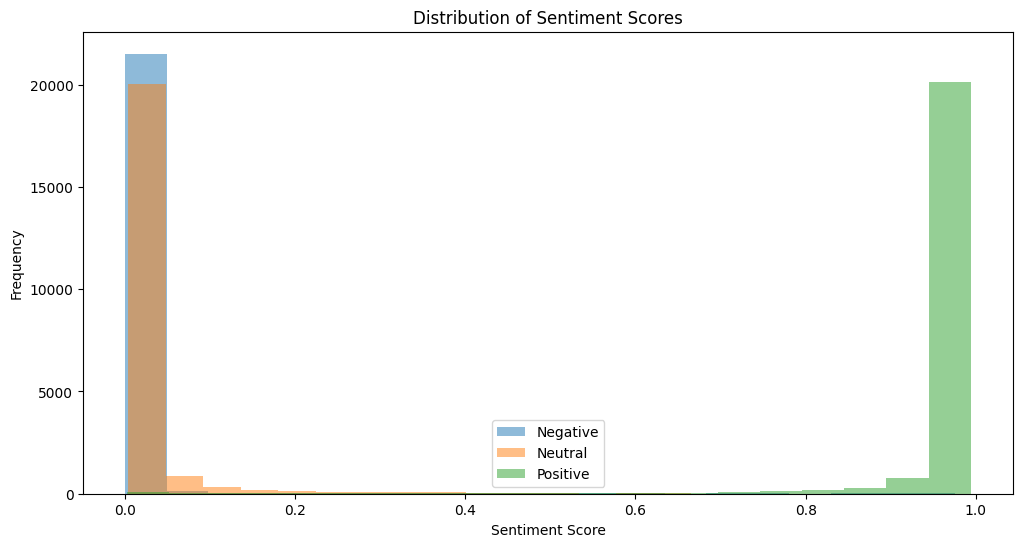

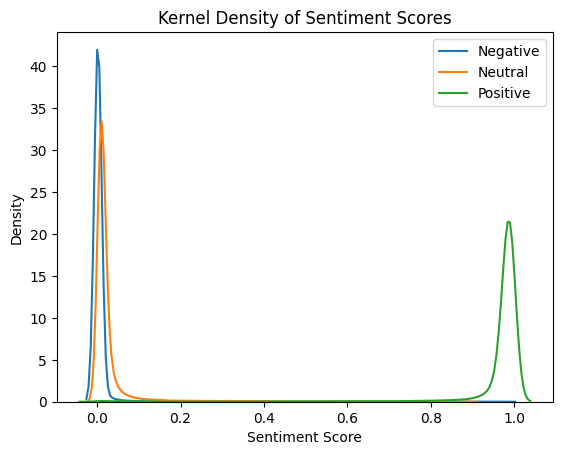

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'res' dictionary stores sentiment scores as:
# res = {review_id: {'roberta_neg': score, 'roberta_neu': score, 'roberta_pos': score}}

# Create a list of sentiment scores for each category
neg_scores = [d['roberta_neg'] for d in results.values()]
neu_scores = [d['roberta_neu'] for d in results.values()]
pos_scores = [d['roberta_pos'] for d in results.values()]

# Plotting histograms
plt.figure(figsize=(12, 6))
plt.hist(neg_scores, bins=20, alpha=0.5, label='Negative')
plt.hist(neu_scores, bins=20, alpha=0.5, label='Neutral')
plt.hist(pos_scores, bins=20, alpha=0.5, label='Positive')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Alternatively, using seaborn for kernel density plots
sns.kdeplot(neg_scores, label='Negative')
sns.kdeplot(neu_scores, label='Neutral')
sns.kdeplot(pos_scores, label='Positive')
plt.title('Kernel Density of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend()
plt.show()

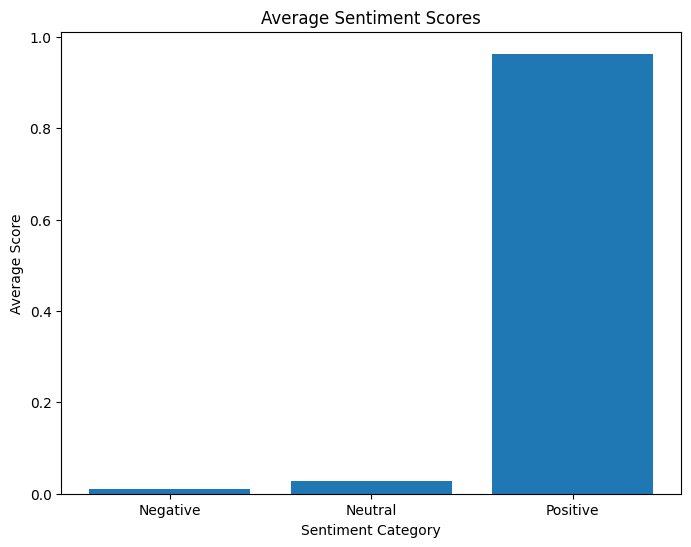

In [51]:
import numpy as np

# Calculate average sentiment scores
avg_neg = np.mean(neg_scores)
avg_neu = np.mean(neu_scores)
avg_pos = np.mean(pos_scores)

# Plotting bar chart
plt.figure(figsize=(8, 6))
plt.bar(['Negative', 'Neutral', 'Positive'], [avg_neg, avg_neu, avg_pos])
plt.title('Average Sentiment Scores')
plt.xlabel('Sentiment Category')
plt.ylabel('Average Score')
plt.show()

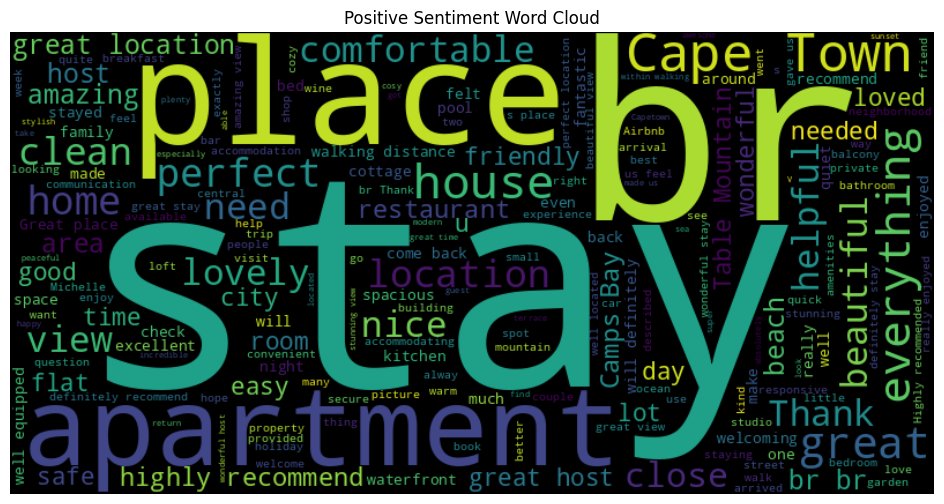

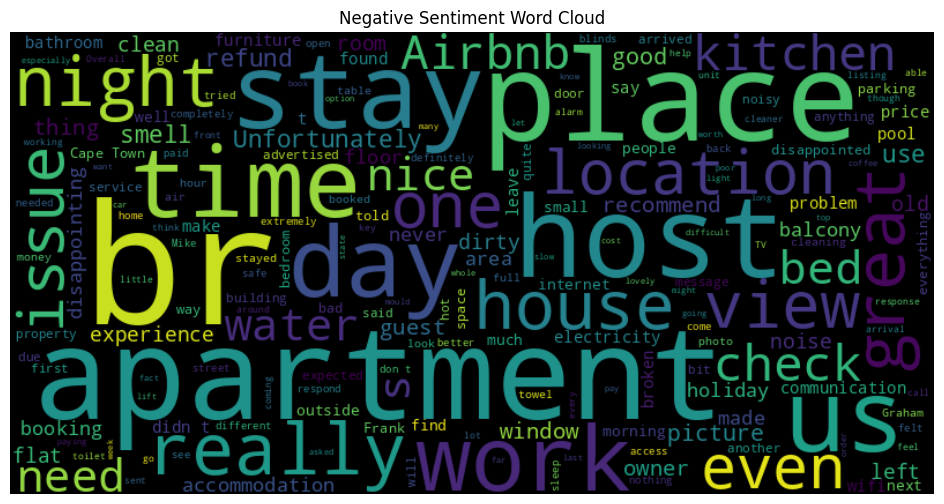

In [52]:
from wordcloud import WordCloud

# Assuming you have the original review text in a column called 'comments' in your DataFrame
# and 'results_df' contains sentiment scores

# Create separate lists of reviews for each sentiment category
positive_reviews = results_df[results_df['roberta_pos'] > 0.5]['comments'].tolist()
negative_reviews = results_df[results_df['roberta_neg'] > 0.5]['comments'].tolist()

# Generate word clouds
positive_wordcloud = WordCloud(width=800, height=400).generate(' '.join(positive_reviews))
negative_wordcloud = WordCloud(width=800, height=400).generate(' '.join(negative_reviews))

# Plot word clouds
plt.figure(figsize=(12, 6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Sentiment Word Cloud')
plt.axis('off')
plt.show()

plt.figure(figsize=(12, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Sentiment Word Cloud')
plt.axis('off')
plt.show()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

<br/>The apartment is spacious with plenty of room for a couple.  You must provide your own paper goods, including toilet paper and paper towels. You'll need your own laundry soap and dryer sheets.  Load shedding (temporary electricity cut-off) is a fact of life in South Africa and will likely affect your stay.  With no electricity you may be eating out, not cooking at the apartment, so don't buy too many groceries up front.  Besides, there are so many good restaurants in Cape Town!  . Error: The expanded size of the tensor (515) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 515].  Tensor sizes: [1, 514]
<br/>TV - channels are a bit limited but why would you watch TV.. Error: The expanded size of the tensor (603) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 603].  Tensor sizes: [1, 514]


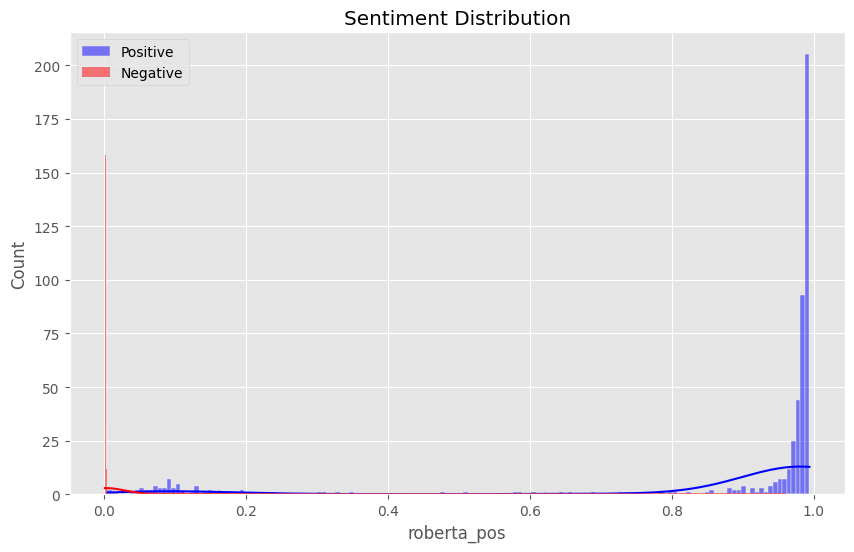

ModuleNotFoundError: No module named 'streamlit'

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import logging

# Logging setup
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Load data
# file_path = os.getenv('REVIEWS_FILE_PATH', 'reviews_500.csv')
# if not os.path.exists(file_path):
#     raise FileNotFoundError(f"File not found: {file_path}")
df = pd.read_csv('reviews_500.csv')

# Initialize model and tokenizer
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Sentiment analysis function
def polarity_scores_roberta(text):
    try:
        encoded_text = tokenizer(text, return_tensors='pt')
        output = model(**encoded_text)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        return {
            'roberta_neg': scores[0],
            'roberta_neu': scores[1],
            'roberta_pos': scores[2]
        }
    except Exception as e:
        logger.error(f"Error processing text: {text}. Error: {e}")
        return {'roberta_neg': np.nan, 'roberta_neu': np.nan, 'roberta_pos': np.nan}

# Process rows
def process_row(row):
    text = row['comments']
    result = polarity_scores_roberta(text)
    result['id'] = row['id']
    return pd.Series(result)

results_df = df.apply(process_row, axis=1)

# Merge results
final_df = pd.merge(df, results_df, on='id', how='left')

# Visualize results
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(final_df['roberta_pos'], kde=True, color='blue', label='Positive', ax=ax)
sns.histplot(final_df['roberta_neg'], kde=True, color='red', label='Negative', ax=ax)
ax.set_title('Sentiment Distribution')
ax.legend()
plt.show()

# Streamlit integration
import streamlit as st
import plotly.express as px
st.title("Sentiment Analysis App")
st.write(final_df[['id', 'comments', 'roberta_pos', 'roberta_neg', 'roberta_neu']])
st.plotly_chart(px.histogram(final_df, x='roberta_pos', title="Positive Sentiment Distribution"))